### Implementation of: https://arxiv.org/pdf/2106.12978

First step: Upload the code files to content/
Then, move to next steps on this notebook.

In [2]:
# import baselines as topic_segmentation_baselines
import numpy as np
import pandas as pd
import torch

#importing local variables and functions
from data_types import (
    TopicSegmentationAlgorithm,
    TopicSegmentationConfig,
    TextTilingHyperparameters,
)
from core import *



# from transformers import RobertaConfig, RobertaModel
# # pretrained roberta model
# configuration = RobertaConfig()
# roberta_model = RobertaModel(configuration)

## Decomposing topic_segmentation_bert() function

In [3]:


def topic_segmentation_bert(
    sentences: list,
    topic_segmentation_configs: TopicSegmentationConfig,
):
    textiling_hyperparameters = TextTilingHyperparameters

    # parallel inference
    batches_features = []
    # for batch_sentences in split_list(
    #     df[caption_col_name], PARALLEL_INFERENCE_INSTANCES
    # ):
        # batches_features.append(get_features_from_sentence(batch_sentences))
    features = get_features_from_sentence(sentences)

    # meeting_id -> list of topic change start times
    segments = {}
    task_idx = 0
    # print("meeting_id -> task_idx")
    # for meeting_id in set(df[meeting_id_col_name]):
    # print("%s -> %d" % (meeting_id, task_idx))
    # task_idx += 1

    # meeting_data = df[df[meeting_id_col_name] == meeting_id]
    # caption_indexes = list(meeting_data.index)

    # timeseries = get_timeseries(caption_indexes, features)

    #get similarity scores of the two consecutive window.
    #e.g. First element  = similarity of 1st and 2nd window
    #e.g. Second element  = similarity of 2st and 3rd window
    block_comparison_score_timeseries = block_comparison_score(
        features, k=15
    )

    #smooth out the similiarity scores by averaging over a smoothing window.
    block_comparison_score_timeseries = smooth(
        block_comparison_score_timeseries,
        n=2,
        s=1,
    )

    #Finds the peaks around one single point, finds the difference between
    #those peaks and the point. Then, finally adds them
    depth_score_timeseries = depth_score(block_comparison_score_timeseries)

    # meeting_start_time = meeting_data[start_col_name].iloc[0]
    # meeting_end_time = meeting_data[end_col_name].iloc[-1]
    # meeting_duration = meeting_end_time - meeting_start_time

    #takes all local maximas
    #filter by a threshold ( threshold is set at 0.6 of the highest score.)
    #max_segment_count is set at 1 segment per minute i.e. 60 per hour.
    #out of the filtered maximas, get the min(max_segment_count, no_of_filtered)
    #then returns the maxima indices
    #I am giving the meeting duration of 600 minutes for nos(to get 10 max topic ).
    #Maybe I can tweak the max_count myself in the function.
    meeting_duration = 600
    segments = depth_score_to_topic_change_indexes(
        depth_score_timeseries,
        meeting_duration,
        topic_segmentation_configs=topic_segmentation_configs,
    )
    print(segments)

    return segments

In [ ]:
!pip install sentence_transformers

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def get_features_from_sentence(sentences):
  batch_features = []
  # Load model from HuggingFace Hub
  tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-roberta-large-v1')
  model = AutoModel.from_pretrained('sentence-transformers/all-roberta-large-v1')

  for sentence in sentences:
    # Tokenize sentence
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    batch_features.append(sentence_embeddings[0])
    # print("Sentence embeddings:")
    # print(sentence_embeddings)
  return batch_features


### Creating the corpus

In [6]:
#S for sentence level, P for paragraph level
corpus_type = 'S'

In [35]:
# Creating example documents

#Title in MD file: Welcome (really don't expect it to give the same heading)
doc_1 = "We invite you to join the Flutter team, which is made up of volunteers and sponsored folk alike!\nThere are many ways to contribute, including writing code, filing issues on GitHub, helping people\non our mailing lists, our chat channels, or on Stack Overflow, helping to triage, reproduce, or\nfix bugs that people have filed, adding to our documentation,\ndoing outreach about Flutter, or helping out in any other way.\n\nWe grant commit access (which includes full rights to the issue\ndatabase, such as being able to edit labels) to people who have gained\nour trust and demonstrated a commitment to Flutter. For more details\nsee the [Contributor access](https://github.com/flutter/flutter/wiki/Contributor-access)\npage on our wiki.\n\nWe communicate primarily over GitHub and [Discord](https://github.com/flutter/flutter/wiki/Chat).\n\nBefore you get started, we encourage you to read these documents which describe some of our community norms:\n\n1. [Our code of conduct](CODE_OF_CONDUCT.md), which stipulates explicitly\n   that everyone must be gracious, respectful, and professional. This\n   also documents our conflict resolution policy and encourages people\n   to ask questions.\n\n2. [Values](https://github.com/flutter/flutter/wiki/Values),\n   which talks about what we care most about"

#Helping out in the issue database
doc_2 = "Welcome: Triage is the process of going through bug reports and determining if they are valid, finding out\nhow to reproduce them, catching duplicate reports, and generally making our issues list\nuseful for our engineers.\n\nIf you want to help us triage, you are very welcome to do so!\n\n1. Join the #hackers-triage [Discord channel](https://github.com/flutter/flutter/wiki/Chat).\n\n2. Read [our code of conduct](CODE_OF_CONDUCT.md), which stipulates explicitly\n   that everyone must be gracious, respectful, and professional. If you\'re helping out\n   with triage, you are representing the Flutter team, and so you want to make sure to\n   make a good impression!\n\n3. Help out as described in our wiki: https://github.com/flutter/flutter/wiki/Triage\n   You won\'t be able to add labels at first, so instead start by trying to\n   do the other steps, e.g. trying to reproduce the problem and asking for people to\n   provide enough details that you can reproduce the problem, pointing out duplicates,\n   and so on. Chat on the #hackers-triage channel to let us know what you\'re up to!\n\n4. Familiarize yourself with our\n   [issue hygiene](https://github.com/flutter/flutter/wiki/Issue-hygiene) wiki page,\n   which covers the meanings of some important GitHub labels and\n   milestones.\n\n5. Once you\'ve been doing this for a while, someone will invite you to the flutter-hackers\n   team on GitHub and you\'ll be able to add labels too. See the\n   [contributor access](https://github.com/flutter/flutter/wiki/Contributor-access) wiki\n   page for details."

#Quality Assurance
doc_3 = "Quality Assurance: One of the most useful tasks, closely related to triage, is finding and filing bug reports. Testing\nbeta releases, looking for regressions, creating test cases, adding to our test suites, and\nother work along these lines can really drive the quality of the product up. Creating tests\nthat increase our test coverage, writing tests for issues others have filed, all these tasks\nare really valuable contributions to open source projects.\n\nIf this interests you, you can jump in and submit bug reports without needing anyone\'s permission!\nThe #quality-assurance channel on our [Discord server](https://github.com/flutter/flutter/wiki/Chat)\nis a good place to talk about what you\'re doing. We\'re especially eager for QA testing when\nwe announce a beta release. See https://github.com/flutter/flutter/wiki/Quality-Assurance for\nmore details.\n\nIf you want to contribute test cases, you can also submit PRs. See the next section\nfor how to set up your development environment, or ask in #hackers-test on Discord.\n\n> As a personal side note, this is exactly the kind of work that first got me into open\n> source. I was a Quality Assurance volunteer on the Mozilla project, writing test cases for\n> browsers, long before I wrote a line of code for any open source project."

#Developing for flutter
doc_4 = "Developing for flutter: If you would prefer to write code, you may wish to start with our list of good first issues for [Flutter](https://github.com/flutter/flutter/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22) or for [Flutter DevTools](https://github.com/flutter/devtools/labels/good%20first%20issue). See the respective sections below for further instructions.\n\n### Framework and Engine\n\nTo develop for Flutter, you will eventually need to become familiar\nwith our processes and conventions. This section lists the documents\nthat describe these methodologies. The following list is ordered: you\nare strongly recommended to go through these documents in the order\npresented.\n\n1. [Setting up your engine development environment](https://github.com/flutter/flutter/wiki/Setting-up-the-Engine-development-environment),\n   which describes the steps you need to configure your computer to\n   work on Flutter\'s engine. If you only want to write code for the\n   Flutter framework, you can skip this step. Flutter\'s engine mainly\n   uses C++, Java, and Objective-C.\n\n2. [Setting up your framework development environment](https://github.com/flutter/flutter/wiki/Setting-up-the-Framework-development-environment),\n   which describes the steps you need to configure your computer to\n   work on Flutter\'s framework. Flutter\'s framework mainly uses Dart.\n\n3. [Tree hygiene](https://github.com/flutter/flutter/wiki/Tree-hygiene),\n   which covers how to land a PR, how to do code review, how to\n   handle breaking changes, how to handle regressions, and how to\n   handle post-commit test failures.\n\n4. [Our style guide](https://github.com/flutter/flutter/wiki/Style-guide-for-Flutter-repo),\n   which includes advice for designing APIs for Flutter, and how to\n   format code in the framework.\n\n5. [Flutter design doc template](https://flutter.dev/go/template),\n   which should be used when proposing a new technical design.  This is a good\n   practice to do before coding more intricate changes.\n   See also our [guidance for writing design docs](https://github.com/flutter/flutter/wiki/Design-Documents).\n\n[![How to contribute to Flutter](https://img.youtube.com/vi/4yBgOBAOx_A/0.jpg)](https://www.youtube.com/watch?v=4yBgOBAOx_A)\n\nIn addition to the documents, there is a video linked above on **How to contribute to Flutter**\nfrom the [Flutter](https://youtube.com/c/flutterdev) YouTube channel,\nthere are many pages on [our Wiki](https://github.com/flutter/flutter/wiki/),\nand an article [Contributing to Flutter: Getting Started](https://medium.com/@ayushbherwani/contributing-to-flutter-getting-started-a0db68cbcd5b)\non Medium that may be of interest. For a curated list of pages see the sidebar\non the wiki\'s home page. They are more or less listed in order of importance.\n\n### DevTools\n\nContributing code to Dart & Flutter DevTools may be a good place to start if you are\nlooking to dip your toes into contributing with a relatively low-cost setup or if you\nare generally excited about improving the Dart & Flutter developer experience.\n\nPlease see the DevTools [CONTRIBUTING.md](https://github.com/flutter/devtools/blob/master/CONTRIBUTING.md)\nguide to get started."

#Outreach
doc_5 = "Outreach: If your interests lie in the direction of developer relations and developer outreach,\nwhether advocating for Flutter, answering questions in fora like\n[Stack Overflow](https://stackoverflow.com/questions/tagged/flutter?sort=Newest&filters=NoAnswers,NoAcceptedAnswer&edited=true)\nor [Reddit](https://www.reddit.com/r/flutterhelp/new/?f=flair_name%3A%22OPEN%22),\nor creating content for our [documentation](https://docs.flutter.dev/)\nor sites like [YouTube](https://www.youtube.com/results?search_query=flutter&sp=EgQIAxAB),\nthe best starting point is to join the #hackers-devrel [Discord channel](https://github.com/flutter/flutter/wiki/Chat).\nFrom there, you can describe what you\'re interested in doing, and go ahead and do it!\nAs others become familiar with your work, they may have feedback, be interested in\ncollaborating, or want to coordinate their efforts with yours"

#API documentation
doc_6 = '''API documentation: Another great area to contribute in is sample code and API documentation. If this is an area that interests you, join our\n[Discord](https://github.com/flutter/flutter/wiki/Chat) server and introduce yourself on the #hackers-deverl, #hackers-framework,\nor #hackers-engine channels, describing your area of interest. As our API docs are integrated into our source code, see the\n"developing for Flutter" section above for a guide on how to set up your developer environment.\n\nTo contribute API documentation, an excellent command of the English language is particularly helpful, as is a careful attention to detail.\nWe have a [whole section in our style guide](https://github.com/flutter/flutter/wiki/Style-guide-for-Flutter-repo#documentation-dartdocs-javadocs-etc)\nthat you should read before you write API documentation. It includes notes on the "Flutter Voice", such as our word and grammar conventions.\n\nIn general, a really productive way to improve documentation is to use Flutter and stop any time you have a question: find the answer, then\ndocument the answer where you first looked for it.\n\nWe also keep [a list of areas that need better API documentation](https://github.com/flutter/flutter/issues?q=is%3Aopen+is%3Aissue+label%3A%22d%3A+api+docs%22+sort%3Areactions-%2B1-desc).\nIn many cases, we have written down what needs to be said in the relevant issue, we just haven\'t gotten around to doing it!\n\nWe\'re especially eager to add sample code and diagrams to our API documentation. Diagrams are generated from Flutter code that\ndraws to a canvas, and stored in a [special repository](https://github.com/flutter/assets-for-api-docs/#readme). It can be a lot of fun\nto create new diagrams for the API docs.\n\n'''

#Releases
doc_7 = "Releases: If you are interested in participating in our release process, which may involve writing release notes and blog posts, coordinating the actual\ngeneration of binaries, updating our release tooling, and other work of that nature, then reach out on the #hackers-releases\nchannel of our [Discord](https://github.com/flutter/flutter/wiki/Chat) server.\n\n\nSocial events in the contributor community"

#Social events
doc_8 = "Social events: Finally, one area where you could have a lot of impact is in contributing to social interactions among the Flutter contributor community itself.\nThis could take the form of organizing weekly video chats on our Discord, or planning tech talks from contributors, for example.\nIf this is an area that is of interest to you, please join our [Discord](https://github.com/flutter/flutter/wiki/Chat) and ping Hixie on the #hackers\nchannel!\n'"


##New file: https://github.com/flutter/flutter/wiki/Contributor-access
# Each doc can be concatenated within itself to get the sub topics(heading is the first paragraph. eg. doc_9[0]).
doc_9 = '''Contributor access. For people who make the occasional contribution to Flutter (filing an issue, submitting the occasional PR, chatting on Discord), the default set of permissions is fine. However, if you are a frequent contributor, whether helping us in triage, or often fixing bugs, or regularly improving our documentation, or regularly helping others in our #help channel, or participating in high-level design discussions and prioritization, you may find your life is more pleasant with commit access (also known as "contributor access", "being a member of the flutter-hackers group", "being a member of the Flutter team").

We grant commit access (which includes full rights to the issue database, such as being able to edit labels, and grants access to our internal chat channels) to people who have gained our trust and demonstrated a commitment to Flutter.

Specifically, if you meet one of the following criteria and you have a sponsor (someone who already has contributor access and agrees that you should be granted access), then please ask your sponsor to propose, on the #server-support chat channel, that you be made a member of the team, and then reply to that message explaining which criteria below you are claiming to meet. The possible criteria are:

You have a long history of participating productively, e.g. in our chat channels, helping with Triage, helping other contributors track down problems, finding meaningful issues in submitted PRs, helping people in our #help channel, etc, all while demonstrating exemplary behavior that closely aligns with our code of conduct.
You have recently submitted several PRs that have landed successfully (received an LGTM, PR was merged, no regressions reported, PR was not reverted), without needing extensive tutoring in the process.
You are employed by a company with a history of contributing to Flutter, for the purpose of yourself regularly contributing to Flutter.
You represent a development team that creates applications, plugins, or packages using Flutter and have a close relationship with our developer relations team, including having a customer label, and have a great need to regularly update labels on issues (see Issue hygiene, Customers). (This is rare.)
Being granted access means that you will be added to the "flutter-hackers" group on GitHub and the "team" role on Discord. This privilege is granted with some expectation of responsibility: contributors are people who care about Flutter and want to help Flutter along our roadmap. A contributor is not just someone who can make changes or comment on issues, but someone who has demonstrated their ability to collaborate with the team, get the most knowledgeable people to review code, contribute high-quality code, follow through to fix bugs (in code or tests), and provide meaningful insights on issues.

We grant access optimistically based on a reasonably small volume of evidence of good faith. Correspondingly, we will remove access quickly if we find our trust has been violated. Contributors with commit access must still follow all our processes and policies, and must follow our code of conduct rigorously. (Please read it, it's stricter than most.)'''

doc_10 = '''Responsibilities
Code of conduct
If you have commit access or "team" access on the Discord server, you are responsible for enforcing our code of conduct.

Our code of conduct is much, much stricter than most. We do not wait until someone has been actively rude or insulting. Being disrespectful in any way is grounds for action. For example, passive-aggressive whining and general unconstructive negativity are all violations of the code of conduct. If someone is in a bad mood, we would rather they avoided contributing to Flutter on that day.

When you see something that might be described as unwelcoming or is in some other way a violation of our code of conduct, promptly contact the offender and ask them to read the code of conduct and consider how they might more effectively espouse its philosophy. Most people react very positively to this.

If they react negatively, or if they continue to make the environment unpleasant, they should be removed from the environment. On Discord, this would be kicking them from the channel. Repeat offenders should be banned. On GitHub, they can be blocked from our organisation (you may need to ask @Hixie or another admin of our GitHub org to do this). Please let the #server-support chat channel know when you do anything like this, so that we can keep an eye on how common it is.

'''

doc_11 = '''Maintaining documentation
Part of being a contributor is making sure our documentation is up to date, including our internal (team-facing) documentation such as this wiki. If you spot something wrong, please fix it! As a contributor, you have access to the wiki.

For the wiki specifically, since there's no code review, it's good to mention on Discord that you've made a change when you make one.
'''

doc_12 = '''
Privileges
Being in the GitHub "flutter-hackers" group gives you the following:

The ability to merge your own PRs once they are reviewed (see Tree Hygiene).

The ability to add labels, milestones, etc, on issues on GitHub (see Issue Hygiene).

PRs will run their tests slightly faster.

Being in the Discord "team" group gives you the following:

The ability to talk without rate-limiting on the #hackers-* channels.

The ability to kick people.

The ability to manage the server emoji.
'''

doc_13 = '''
Process
The actual process (as followed by Flutter repo admins) is as follows:

Verify that they qualify under all the terms described above. Make sure they have a sponsor who isn't you.
Verify the identity of the person making the request. Ask them to confirm, on Discord, that they have read the style guide, issue or tree hygiene wiki page, code of conduct, and other documents relevant to them.
Add them to our private spreadsheet (go/flutter-organization-members).
Click the "Add a member" button on the flutter-hackers team page on GitHub.
Type their name in the text field, select them, then click the "Invite" button.
Add them to the "team" group on Discord. Be sure to verify that you are promoting the right person; multiple people can have the same nickname on Discord!
For new Googlers joining the team: You need to ask someone in the team to add you to get added. It's not an automatic process after you join the flutter Google group.
'''

doc_14 = '''Inactivity
We occasionally check for account with commit access that have not been used for a while. It takes very little to count as "active" (e.g. commenting on an issue, even adding an emoji reaction to an issue). If your account has been inactive for over a year we will try to reach out (e.g. by e-mail or on Discord) before removing access.

If your account access was removed but you wish to return to contributing to Flutter, you are most welcome to do so; just reach out on the Discord (see Chat) and ask someone to renominate you according to the process described above.
'''

doc_15 = '''
Access rights to Flutter dashboard
The Flutter dashboard shows what recently landed and what tests passed or failed with those commits. To see rerun tasks, you need to be added to an allowlist. Anyone with commit access is eligible to be added to that allowlist, but only certain team members have the permissions required to update the backend database where the permissions are stored. To get access, ask on #hackers-infra to be added to the allowlist.
'''

doc_16 = '''
Adding a contributor to Flutter Dashboard
This is only for team members with access to the Flutter Dashboard Datastore.

Open flutter-dashboard datastore
Click Create Entity
Click Email: Empty -> Edit property. Insert contributor Google account
Click Create
'''

doc_17 = '''
Access to LUCI recipes and configuration repositories
If you need access to the LUCI recipes, you need to be added to the relevant ACLs. Ask in #hackers-infra to be added to the LUCI ACLs.
'''

doc_18 = '''
Process
A Googler has to be the one to grant permission. Documentation on how to use the relevant tools is available at: https://goto.google.com/gob-ctl#add-or-remove-users-in-host-acl
'''

doc_19 = '''
Access to Flutter Gold
If you need access to triage images in Flutter Gold, you need to be added as an authorized user. Users in the @google.com domain are already authorized to use Flutter Gold, but @gmail.com addresses can also be added to the allow list.
'''

doc_20 = '''
Process
The list of authorized users is maintained in the skia build-bot repository, in this file. Googlers can submit a change to add to the authorized users.

This repository is also mirrored on GitHub.
'''

doc_21 = '''
fcontrib.org accounts
If you are a team member who wants to share design docs (see Chat) but you don't want to use your own personal account, you can ask a Flutter admin for an fcontrib.org account. Ping @Hixie or another admin in the #server-support channel on Discord.
'''

doc_22  = '''
Process
You’ll need the user’s email account somewhere else, first and last name, and desired fcontrib.org account login before you begin.

To add a fcontrib.org participant:

Open an incognito window and log in using your admin fcontrib credentials at https://admin.google.com/. (q.v. valentine)
Under “Users” in the upper left of the main content area, click “Add a User” and follow the prompts.
For a password, choose “Generate Password” and email the password to the new account holder using their non-fcontrib account -- they’ll be able to log in with that and then choose a new password.
'''

doc_23 = '''
Review teams
Some parts of the codebase have teams specified so that PRs get round-robin assigned for review.

To join one of these teams, request members be added/deleted, or change any settings, ping @Hixie on Discord. Members must be a member of the Flutter Hackers group (as documented at the top of this page).

We currently have the following review teams:

android-reviewers: for folks working on the Android port of Flutter; use #hackers-android for discussions.
devtools-reviewers: for the devtools repo; use #hackers-devexp for discussions.
website-reviewers: for folks working on www.flutter.dev and docs.flutter.dev; use #hackers-devrel for discussions.
To create a new team, contact @Hixie. You will also need to create a CODEOWNERS file to actually trigger the review assignment.

'''

doc_24 = '''
Pusher permissions
Some branches are protected to avoid accidents. Only people in the specific branches can push to them. Anyone can ask to be added or removed from these groups, they exist only to reduce accidents, not for security.

To join one of these teams, request members be added/deleted, or change any settings, ping @Hixie on Discord. Members must be a member of the Flutter Hackers group (as documented at the top of this page).

The following groups have been defined for these purposes: pushers-beta, pushers-fuchsia
'''
# Create corpus
corpus = [doc_1, doc_2, doc_3, doc_4, doc_5, doc_6, doc_7, doc_8, doc_9, doc_10, doc_11, doc_12, doc_13, doc_14, doc_15, doc_16, doc_17, doc_18, doc_19, doc_20, doc_21, doc_22, doc_23, doc_24]



Convert the paragraphs to sentences. We can do this for whole document as well (for our actual documents).

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def generate_sentences(para):
  '''
  returns a list of sentences given a a paragraph
  '''
  sentences = sent_tokenize(para)
  return sentences

sent_corpus = []

#this is a ground truth data. It contains the indices where there are actual segments.
#I'm leaving the 0th index since our code does that below.
#We may need to change that later on.
section_indices_ground= []

for doc in corpus:
  #keep on adding new sentences from new segments
  sent_corpus = sent_corpus + generate_sentences(doc)
  # print(len(sent_corpus))
  section_indices_ground.append(len(sent_corpus)-1)

if corpus_type=='S':
  corpus = sent_corpus

print(corpus)

#### First try with the sections but I don't expect good results since the paper worked on sentence level.
#### After that try the sentence level decomposition. (Maybe the code has something.)


# PROCESSING

Unpacking topic_segmentation_bert() function



In [ ]:

textiling_hyperparameters = TextTilingHyperparameters

# parallel inference
batches_features = []
# for batch_sentences in split_list(
#     df[caption_col_name], PARALLEL_INFERENCE_INSTANCES
# ):
    # batches_features.append(get_features_from_sentence(batch_sentences))
features = get_features_from_sentence(corpus)

print(features)


In [10]:
print(len(features[0]))
print(len(features))


1024
177


In [11]:
segments = {}
task_idx = 0
# print("meeting_id -> task_idx")
# for meeting_id in set(df[meeting_id_col_name]):
# print("%s -> %d" % (meeting_id, task_idx))
# task_idx += 1

# meeting_data = df[df[meeting_id_col_name] == meeting_id]
# caption_indexes = list(meeting_data.index)

# timeseries = get_timeseries(caption_indexes, features)

#get similarity scores of the two consecutive window.
#e.g. First element  = similarity of 1st and 2nd window
#e.g. Second element  = similarity of 2st and 3rd window
#default k was 15. I modified it for small corpus size
# block_comparison_score_timeseries = block_comparison_score(
#     features, k=5
# )

#unpacking block_comparison_score() function
res = []
k=5
for i in range(k, len(features) - k):

    #unpacking compute_window function for first window features
    stack = torch.stack([features for features in features[i-k:i+1]])
    stack = stack.unsqueeze(
        0
    )
    stack_size = i+1 - (i-k)
    pooling = torch.nn.MaxPool2d((stack_size - 1, 1))
    first_window_features = pooling(stack)
    #end of compute_window_function (the stack size varies)

    #unpacking compute_window function for second window features
    stack = torch.stack([features for features in features[i+1:i+k+2]])
    stack = stack.unsqueeze(
        0
    )
    stack_size = i+k+2 - (i+1)
    pooling = torch.nn.MaxPool2d((stack_size - 1, 1))
    second_window_features = pooling(stack)
    #end of compute_window_function (the stack size varies)

    # print(first_window_features)
    # first_window_features = compute_window(features, i - k, i + 1)
    # second_window_features = compute_window(features, i + 1, i + k + 2)
    # first_window_features = features[i - k:i + 1]
    # print(first_window_features)
    # second_window_features = features[i + 1:i + k + 2]
    # print(second_window_features)
    res.append(
        sentences_similarity(first_window_features[0], second_window_features[0])
    )

#end of block_comparison_score() function unpacking, equivalent returned result = res

In [12]:
block_comparison_score_timeseries = res

In [13]:
#smooth out the similiarity scores by averaging over a smoothing window.
block_comparison_score_timeseries = smooth(
    block_comparison_score_timeseries,
    n=2,
    s=1,
)

#Finds the peaks around one single point, finds the difference between
#those peaks and the point. Then, finally adds them
# depth_score_timeseries = depth_score(block_comparison_score_timeseries)

timeseries = block_comparison_score_timeseries
#unpacking depth_score() function to help in visualization
depth_scores = []
for i in range(1, len(timeseries) - 1):
    left, right = i - 1, i + 1
    while left > 0 and timeseries[left - 1] > timeseries[left]:
        left -= 1
    while (
        right < (len(timeseries) - 1) and timeseries[right + 1] > timeseries[right]
    ):
        right += 1
    depth_scores.append(
        (timeseries[right] - timeseries[i]) + (timeseries[left] - timeseries[i])
    )
depth_score_timeseries = depth_scores
#end of unpacking depth_score() function



Length of depth score timeseries (should be actual length-2*window size+1?) =  165


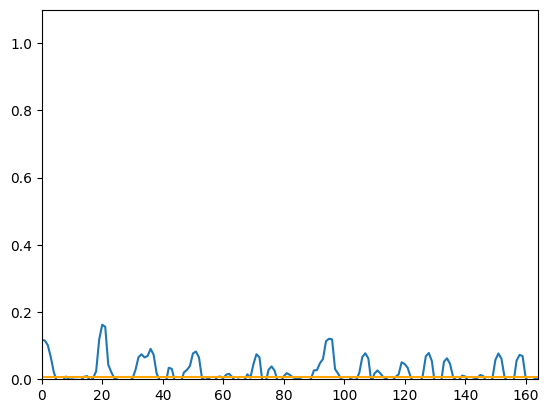

In [40]:
import matplotlib.pyplot as plt

TOPIC_CHANGE_THRESHOLD = 0.05

n = len(depth_score_timeseries)
print("Length of depth score timeseries (should be actual length-2*window size+1?) = ", n)
threshold = TOPIC_CHANGE_THRESHOLD * max(depth_score_timeseries)
# Plot filtered scores
plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(depth_score_timeseries)

# Plot threshold metadata
plt.plot(np.repeat(threshold, len(depth_score_timeseries)), c='orange')
# plt.plot(segment_ids, filtered_scores[segment_ids], 'o', c='red')

In [41]:
#unpacking depth_score_to_topic_change_indexes

#capped: add a max segment limit so there are not too many segments, used for UI improvements on the Workplace TeamWork product

capped = False
average_segment_length = 60 #we won't be using this
meeting_duration = 600

print("DEPTH_SCORE_TIMESERIES:")
print(list(depth_score_timeseries))

if depth_score_timeseries == []:
    print("Empty depth score series.")

local_maxima_indices, local_maxima = get_local_maxima(depth_score_timeseries)
print(f"Local maxima: {local_maxima}")
print(f"Number of local maxima : {len(local_maxima)}")

if local_maxima == []:
    print("No local maxima found")

if capped:  # capped is segmentation used for UI
    # sort based on maxima for pruning
    local_maxima, local_maxima_indices = arsort2(local_maxima, local_maxima_indices)

    # local maxima are sorted by depth_score value and we take only the first K
    # where the K+1th local maxima is lower then the threshold
    for thres in range(len(local_maxima)):
        if local_maxima[thres] <= threshold:
            break

    max_segments = int(meeting_duration / average_segment_length)
    slice_length = min(max_segments, thres)

    local_maxima_indices = local_maxima_indices[:slice_length]
    local_maxima = local_maxima[:slice_length]

    # after pruning, sort again based on indices for chronological ordering
    local_maxima_indices, _ = arsort2(local_maxima_indices, local_maxima)

else:  # this is the vanilla TextTiling used for Pk optimization
    filtered_local_maxima_indices = []
    filtered_local_maxima = []

    for i, m in enumerate(local_maxima):
        if m > threshold:
            filtered_local_maxima.append(m)
            filtered_local_maxima_indices.append(i)

    local_maxima = filtered_local_maxima
    local_maxima_indices = filtered_local_maxima_indices

print("Filtered LOCAL_MAXIMA_INDICES:")
print(list(local_maxima_indices))
print("Filtered LOCAL_MAXIMA_VALUES:")
print(list(local_maxima))

segments = local_maxima_indices

DEPTH_SCORE_TIMESERIES:
[0.11666322266682982, 0.1156111410818994, 0.10177714144811034, 0.06587273394688964, 0.020977383013814688, -0.005462194327265024, -0.009111920837312937, -0.003955085441702977, 0.00820576338446699, -0.0005092675855848938, -0.0002654340642038733, -0.001470779490773566, -0.0017954721479327418, -0.0021917157610005233, 0.0074159729683742626, 0.009408167933543155, -0.004237545516389218, 0.0033264058963595744, 0.024353736483931243, 0.1182686544602709, 0.1624113676651766, 0.1562593392896381, 0.0434110156952463, 0.02118209186743547, 0.003154832264092189, -0.0006313807838105312, -0.00494547896692632, -0.005417339745682925, -0.004110293796408926, -0.004363586628775451, 0.0020632895724203015, 0.02778628362415625, 0.065780982752362, 0.07429704576644769, 0.06502038206179661, 0.06925262374879959, 0.09057446068909769, 0.07287659519177181, 0.016998092697950162, -0.0024639033227195073, -0.01428770981808547, -0.012777859943634229, 0.03432945578272106, 0.03110491753757072, -0.004953

### Need to figure out if the given segments are giving actual topic changes or how do we backtrack the local maxima indices to actual sentences.

End of unpacking the function topic_segmentation_bert()

### Creating binary code of the segments found

In [42]:
#this is to offset the indices by k in actual data corpus we have
#since we start to get the values for depth score for a window of size k, ending at kth element in block comparison (windows)
#example: we get the first score only at 5th element, then at 6th element all the way to (n-k)th element.
offset = k
actual_sentence_indices = []
for idx, score in enumerate(depth_score_timeseries):
  if score in local_maxima:
    actual_sentence_indices.append(idx + offset)


In [43]:
actual_sentence_indices

[13,
 20,
 25,
 38,
 41,
 47,
 56,
 64,
 67,
 73,
 76,
 81,
 86,
 100,
 112,
 116,
 124,
 133,
 139,
 144,
 150,
 156,
 163]

In [44]:
# we need to convert from topic changes indexes to topic changes binaries
predicted_segmentation = [0] * len(corpus)
for idx in actual_sentence_indices:
    predicted_segmentation[idx] = 1

print(predicted_segmentation)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Save the segmentation in a text file with annotations

In [45]:
file_name = 'segmented_text.txt'
file1  = open(file_name, "w")
for idx, sentence in enumerate(corpus):
  if idx in actual_sentence_indices:
    file1.write("\n\n-----------------------------<SEGMENT>--------------------------\n\n")
  file1.write(sentence)
file1.close()

## Compare the result with the ground truth

In [37]:
section_indices_ground

[9,
 25,
 36,
 61,
 64,
 76,
 78,
 81,
 99,
 112,
 116,
 122,
 133,
 139,
 143,
 146,
 148,
 150,
 152,
 155,
 157,
 162,
 170,
 176]